In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split


In [3]:
data = np.load('./blast_discrim.npz')

for key in data.files:
    print(f"{key}: {data[key]}")

X: [[1.76 2.01]
 [1.18 1.55]
 [1.79 1.95]
 ...
 [2.09 2.26]
 [1.05 1.31]
 [1.41 1.2 ]]
Y: [1. 1. 1. ... 0. 0. 0.]


### <b>a. Histograms</b>

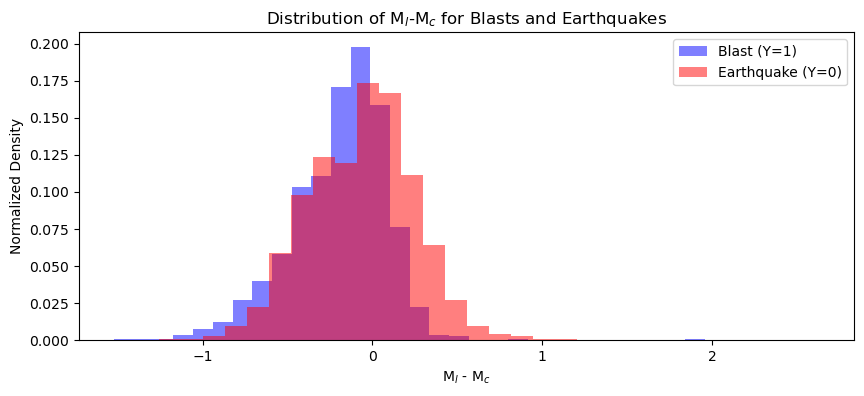

In [4]:
Ml = data['X'][:,0]
Mc = data['X'][:,1]
diff = Ml - Mc

plt.figure(figsize=(10, 4))

mask_blast = data['Y'] == 1
mask_quake = data['Y'] == 0

plt.hist(diff[mask_blast], bins=30, alpha=0.5, 
         color='blue', label='Blast (Y=1)',
         weights=np.ones_like(diff[mask_blast])/len(diff[mask_blast]))
plt.hist(diff[mask_quake], bins=30, alpha=0.5, 
         color='red', label='Earthquake (Y=0)',
         weights=np.ones_like(diff[mask_quake])/len(diff[mask_quake]))

plt.xlabel('M$_l$ - M$_c$')
plt.ylabel('Normalized Density')
plt.title('Distribution of M$_l$-M$_c$ for Blasts and Earthquakes')
plt.legend()
plt.show()

### <b>b. Split data into partitions</b>

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    diff, data["Y"], 
    test_size=0.25,
    random_state=42,
    stratify=data["Y"]  # Maintain class distribution
)


### <b>c-d. Train binary logistic classifier and plot loss history</b>

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score

In [ ]:
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test  = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test  = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1) # in_feature, out_feature (# of neurons)
    
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

In [8]:
def train_model(learning_rate):
    model = LogisticRegressionModel(input_dim=1)
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    train_losses = []
    test_losses = []
    
    for epoch in range(1000):
        # Forward propagation
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        train_losses.append(loss.item())
        
        # Backward prop.
        optimizer.zero_grad()  # clear gradients
        loss.backward()        # backward propagation
        optimizer.step()
        
        # Evaluate on test set without gradient computation
        with torch.no_grad(): 
            y_test_pred = model(X_test)
            test_loss = criterion(y_test_pred, y_test)
            test_losses.append(test_loss.item())
    
    # finally, calculate precision and recall
    # training data
    y_train_pred_class = (y_pred >= 0.5).float()
    y_train_np      = y_train.cpu().numpy()
    y_train_pred_np = y_train_pred_class.cpu().numpy()

    precision_train = precision_score(y_train_np, y_train_pred_np, average=None, zero_division=0)
    recall_train    = recall_score(y_train_np, y_train_pred_np, average=None, zero_division=0)

    # test data
    y_test_pred_class = (y_test_pred >= 0.5).float()
    y_test_np      = y_test.cpu().numpy()
    y_test_pred_np = y_test_pred_class.cpu().numpy()

    precision_test = precision_score(y_test_np, y_test_pred_np, average=None, zero_division=0)
    recall_test    = recall_score(y_test_np, y_test_pred_np, average=None, zero_division=0)

    return train_losses, test_losses, (precision_train, recall_train, precision_test, recall_test)


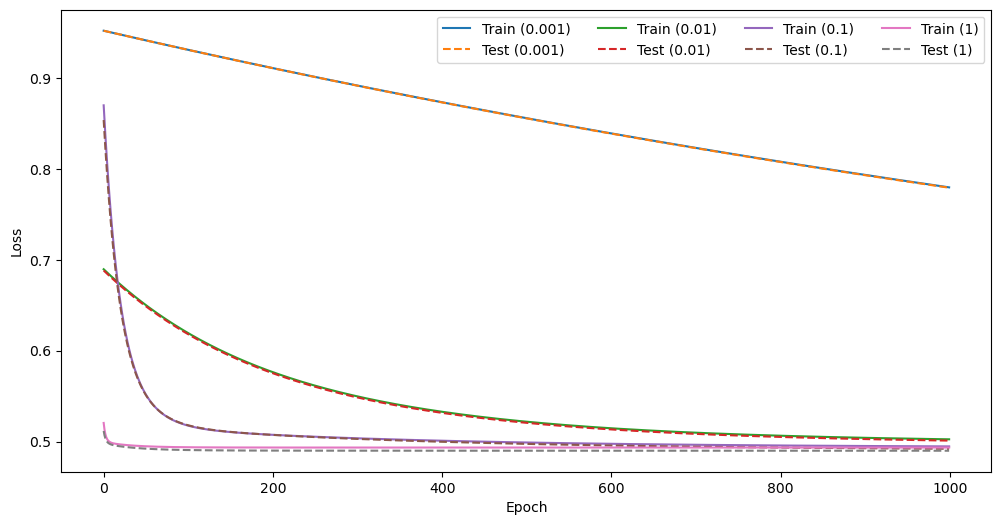

In [19]:
torch.manual_seed(100)
learning_rates = [0.001, 0.01, 0.1, 1]
history = {}
models  = {}

for lr in learning_rates:
    train_losses, test_losses, scores = train_model(lr)
    history[lr] = (train_losses, test_losses)
    models[lr]  = scores

plt.figure(figsize=(12, 6))
for lr, (train_losses, test_losses) in history.items():
    plt.plot(train_losses, label=f'Train ({lr})')
    plt.plot(test_losses, linestyle='--', label=f'Test ({lr})')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(ncols=len(learning_rates))

### <b>e. Precision and Recall</b>

In [10]:
for lr, scores in models.items():
    print(f"\nLearning Rate: {lr}")
    print(f"Train Precision: Earthquake - {scores[0][0]:.4f}, Blast - {scores[0][1]:.4f}")
    print(f"Train  Recall: Earthquake - {scores[1][0]:.4f}, Blast - {scores[1][1]:.4f}")
    print(f"Test Precision: Earthquake - {scores[2][0]:.4f}, Blast - {scores[2][1]:.4f}")
    print(f"Test  Recall: Earthquake - {scores[3][0]:.4f}, Blast - {scores[3][1]:.4f}")


Learning Rate: 0.001
Train Precision: Earthquake - 0.9796, Blast - 0.2235
Train  Recall: Earthquake - 0.1150, Blast - 0.9907
Test Precision: Earthquake - 0.9580, Blast - 0.2195
Test  Recall: Earthquake - 0.1021, Blast - 0.9826

Learning Rate: 0.01
Train Precision: Earthquake - 0.7955, Blast - 0.0000
Train  Recall: Earthquake - 1.0000, Blast - 0.0000
Test Precision: Earthquake - 0.7956, Blast - 0.0000
Test  Recall: Earthquake - 1.0000, Blast - 0.0000

Learning Rate: 0.1
Train Precision: Earthquake - 0.7955, Blast - 0.0000
Train  Recall: Earthquake - 1.0000, Blast - 0.0000
Test Precision: Earthquake - 0.7956, Blast - 0.0000
Test  Recall: Earthquake - 1.0000, Blast - 0.0000

Learning Rate: 1
Train Precision: Earthquake - 0.7959, Blast - 0.5000
Train  Recall: Earthquake - 0.9991, Blast - 0.0035
Test Precision: Earthquake - 0.7967, Blast - 1.0000
Test  Recall: Earthquake - 1.0000, Blast - 0.0070


### <b>f. </b>
From the histogram in (a), the distributions of two groups greatly overlap, and the number of earthquake data is much larger than blast data. 

This results in the tendency of models to predict earthquake and incorrectly classify blast as earthquake, at any learning rate.

### <b>g. Resample -> balanced</b>

In [11]:
from sklearn.utils import resample

In [ ]:
y = data['Y'] 

blast_indices = np.where(y == 1)[0]
earthquake_indices = np.where(y == 0)[0]

earthquake_indices_downsampled = resample(
    earthquake_indices,
    n_samples=len(blast_indices),
    random_state=1,
    replace=False  
)

balanced_indices = np.concatenate([blast_indices, earthquake_indices_downsampled])
np.random.shuffle(balanced_indices)

diff2 = diff[balanced_indices]
y2    = y[balanced_indices]

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    diff2, y2, 
    test_size=0.25,
    random_state=42,
    stratify=y2 
)

X_train2 = torch.tensor(X_train2, dtype=torch.float32).unsqueeze(1)
y_train2 = torch.tensor(y_train2, dtype=torch.float32).unsqueeze(1)
X_test2  = torch.tensor(X_test2, dtype=torch.float32).unsqueeze(1)
y_test2  = torch.tensor(y_test2, dtype=torch.float32).unsqueeze(1)

In [13]:
# redefine model
def train_model2(learning_rate):
    model = LogisticRegressionModel(input_dim=1)
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    train_losses = []
    test_losses  = []
    
    for epoch in range(1000):
        # Forward propagation
        y_pred = model(X_train2)
        loss = criterion(y_pred, y_train2)
        train_losses.append(loss.item())
        
        # Backward prop.
        optimizer.zero_grad()  # clear gradients
        loss.backward()        # backward propagation
        optimizer.step()
        
        # Evaluate on test set without gradient computation
        with torch.no_grad(): 
            y_test_pred = model(X_test2)
            test_loss = criterion(y_test_pred, y_test2)
            test_losses.append(test_loss.item())
    
    # finally, calculate precision and recall
    # training data
    y_train_pred_class = (y_pred >= 0.5).float()
    # Convert to numpy for sklearn metrics
    y_train_np      = y_train2.cpu().numpy()
    y_train_pred_np = y_train_pred_class.cpu().numpy()
    
    # Calculate precision and recall for each class
    precision_train = precision_score(y_train_np, y_train_pred_np, average=None, zero_division=0)
    recall_train    = recall_score(y_train_np, y_train_pred_np, average=None, zero_division=0)

    # test data
    y_test_pred_class = (y_test_pred >= 0.5).float()
    # Convert to numpy for sklearn metrics
    y_test_np      = y_test2.cpu().numpy()
    y_test_pred_np = y_test_pred_class.cpu().numpy()
    
    # Calculate precision and recall for each class
    precision_test = precision_score(y_test_np, y_test_pred_np, average=None, zero_division=0)
    recall_test    = recall_score(y_test_np, y_test_pred_np, average=None, zero_division=0)

    return train_losses, test_losses, (precision_train, recall_train, precision_test, recall_test)


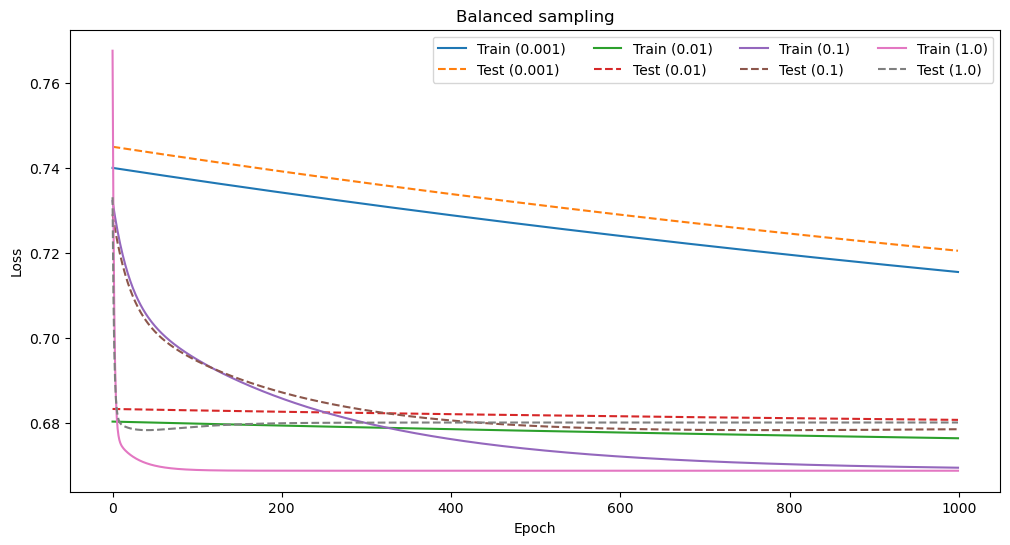

In [20]:
torch.manual_seed(100)
learning_rates = [0.001, 0.01, 0.1, 1.]
history = {}
models  = {}

for lr in learning_rates:
    train_losses, test_losses, scores = train_model2(lr)
    history[lr] = (train_losses, test_losses)
    models[lr]  = scores

# Plot the loss history
plt.figure(figsize=(12, 6))
for lr, (train_losses, test_losses) in history.items():
    plt.plot(train_losses, label=f'Train ({lr})')
    plt.plot(test_losses, linestyle='--', label=f'Test ({lr})')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Balanced sampling')
plt.legend(ncols=len(learning_rates))

In [15]:
print("Balanced Sampling Results:")
for lr, scores in models.items():
    print(f"\nLearning Rate: {lr}")
    print(f"Train Precision: Earthquake - {scores[0][0]:.4f}, Blast - {scores[0][1]:.4f}")
    print(f"Train  Recall: Earthquake - {scores[1][0]:.4f}, Blast - {scores[1][1]:.4f}")
    print(f"Test Precision: Earthquake - {scores[2][0]:.4f}, Blast - {scores[2][1]:.4f}")
    print(f"Test  Recall: Earthquake - {scores[3][0]:.4f}, Blast - {scores[3][1]:.4f}")

Balanced Sampling Results:

Learning Rate: 0.001
Train Precision: Earthquake - 0.9091, Blast - 0.5026
Train  Recall: Earthquake - 0.0116, Blast - 0.9988
Test Precision: Earthquake - 0.8333, Blast - 0.5035
Test  Recall: Earthquake - 0.0174, Blast - 0.9965

Learning Rate: 0.01
Train Precision: Earthquake - 0.5629, Blast - 0.5673
Train  Recall: Earthquake - 0.5819, Blast - 0.5482
Test Precision: Earthquake - 0.5850, Blast - 0.5893
Test  Recall: Earthquake - 0.5993, Blast - 0.5749

Learning Rate: 0.1
Train Precision: Earthquake - 0.5506, Blast - 0.5607
Train  Recall: Earthquake - 0.6005, Blast - 0.5099
Test Precision: Earthquake - 0.5733, Blast - 0.5843
Test  Recall: Earthquake - 0.6132, Blast - 0.5436

Learning Rate: 1.0
Train Precision: Earthquake - 0.5506, Blast - 0.5607
Train  Recall: Earthquake - 0.6005, Blast - 0.5099
Test Precision: Earthquake - 0.5733, Blast - 0.5843
Test  Recall: Earthquake - 0.6132, Blast - 0.5436


⭐️ With proper learning rate, the trade-off between P and R reaches a sweetspot where the model gives a reasonable prediction. However, compared with unbalanced sample, the overall performance (the loss at same poch) degrades, due to limited number of samples.

### <b>h. Find the hyperplane</b>

In [16]:
MyLr    = 0.1
MyModel = LogisticRegressionModel(input_dim=1)
criterion = nn.BCELoss()
optimizer = optim.SGD(MyModel.parameters(), lr=MyLr)

for epoch in range(500):
    # Forward propagation
    y_pred = MyModel(X_train2)
    loss = criterion(y_pred, y_train2)
    train_losses.append(loss.item())

    # Backward prop.
    optimizer.zero_grad()  # clear gradients
    loss.backward()        # backward propagation
    optimizer.step()


In [17]:
ml_min, ml_max = Ml.min() - 0.5, Ml.max() + 0.5
mc_min, mc_max = Mc.min() - 0.5, Mc.max() + 0.5

ml_grid = np.linspace(ml_min, ml_max, 300)
mc_grid = np.linspace(mc_min, mc_max, 300)
Ml_mesh, Mc_mesh = np.meshgrid(ml_grid, mc_grid)

diff_mesh = Ml_mesh - Mc_mesh

with torch.no_grad():
    diff_flat = torch.tensor(diff_mesh.flatten(), dtype=torch.float32).unsqueeze(1)
    Z = MyModel(diff_flat).numpy().reshape(Ml_mesh.shape)


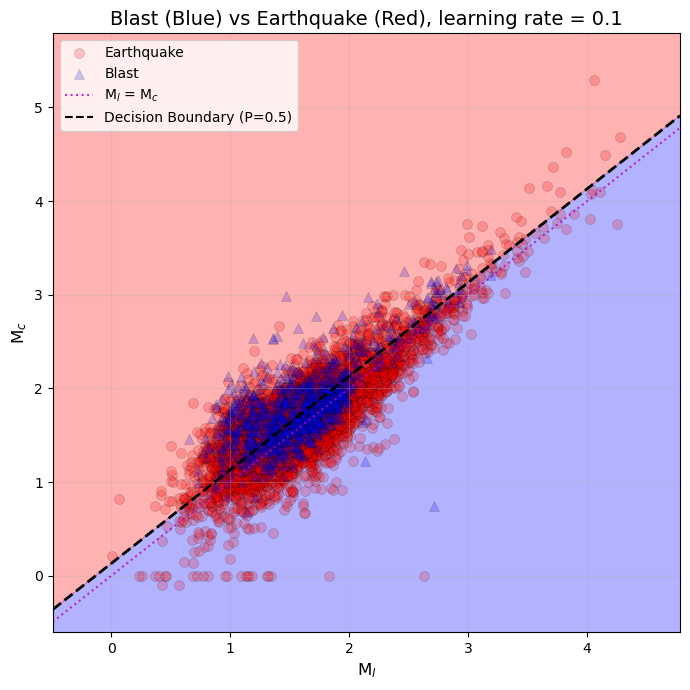

In [18]:
plt.figure(figsize=(7, 7))

# Plot decision regions (contour fill)
contour = plt.contourf(Ml_mesh, Mc_mesh, Z, levels=[0, 0.5, 1], 
                       colors=['b', 'r'], alpha=0.3)

plt.contour(Ml_mesh, Mc_mesh, Z, levels=[0.5], 
           colors='black', linewidths=2, linestyles='--')

plt.scatter(Ml[y == 0], Mc[y == 0], 
           c='r', marker='o', s=50, alpha=0.2, 
           label='Earthquake', edgecolors='k', linewidth=0.5)
plt.scatter(Ml[y == 1], Mc[y == 1], 
           c='b', marker='^', s=50, alpha=0.2, 
           label='Blast', edgecolors='k', linewidth=0.5)

diag_range = np.linspace(min(ml_min, mc_min), max(ml_max, mc_max), 100)
plt.plot(diag_range, diag_range, 'm', linestyle=':', alpha=0.8, label='M$_l$ = M$_c$')

plt.plot([], [], 'k--', label='Decision Boundary (P=0.5)')

plt.xlabel('M$_l$', fontsize=12)
plt.ylabel('M$_c$', fontsize=12)
plt.xlim(ml_min, ml_max)
plt.ylim(mc_min, mc_max)
plt.title(f'Blast (Blue) vs Earthquake (Red), learning rate = {MyLr}', fontsize=14)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()